In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model

In [2]:
base_dir = "./Alzheimer/"

data_dir = base_dir + "Axial"
model1_path = base_dir + "model1.hdf5"
final_model_path = base_dir + "best_model.hdf5"

model1 = load_model(filepath=model1_path)
final_model = load_model(filepath=final_model_path)

os.listdir(data_dir)

['AD', 'CN', 'MCI']

In [3]:
CLASSES = ['CN', 'MCI', 'AD']
IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42

In [4]:
dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    seed=SEED
)

Found 5154 files belonging to 3 classes.


In [5]:
number_of_images = {}
for class_name in CLASSES:
    number_of_images[class_name] = len(os.listdir(data_dir+"/"+class_name))
image_count_df = pd.DataFrame(number_of_images.values(),
                              index=number_of_images.keys(),
                              columns=["Number of Images"])
display(image_count_df)
print("\nSum of Images: {}".format(image_count_df.sum()[0]))

,Number of Images
CN,1440
MCI,2590
AD,1124



Sum of Images: 5154


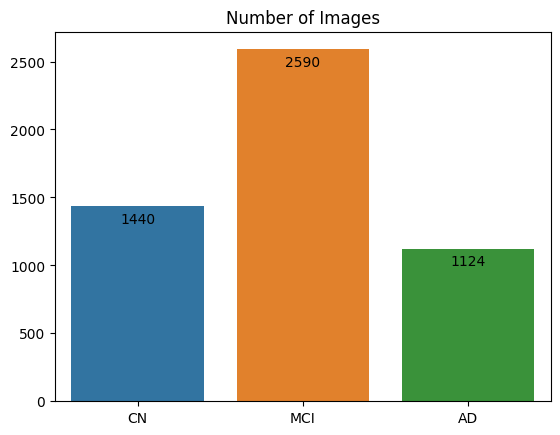

In [6]:
ax = sns.barplot(data=image_count_df.T)

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()-200),
                ha='center', va='center', fontsize=10, color='black',xytext=(0,10),
                textcoords='offset points')

plt.title('Number of Images')
plt.show()

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(label_batch.shape)
    break

(32, 256, 256, 3)
[2 2 1 1 1 1 1 2 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 2 1 0 0 0]
(32,)


In [8]:
np.min(img_batch), np.max(img_batch)

(0.0, 255.0)

In [9]:
print(np.unique(label_batch))
print(dataset.class_names)

[0 1 2]
['CN', 'MCI', 'AD']


In [10]:
class_dict = dict(zip(np.unique(label_batch),dataset.class_names))
class_dict

{0: 'CN', 1: 'MCI', 2: 'AD'}

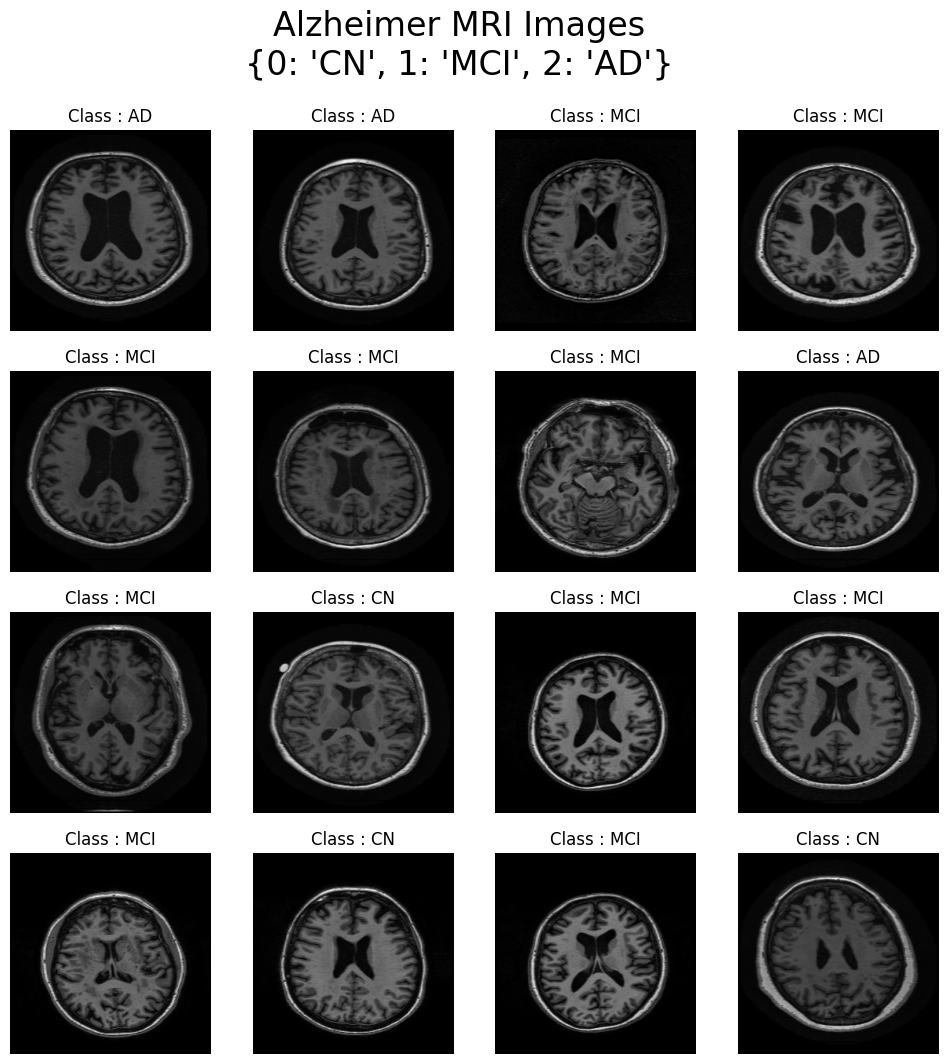

In [11]:
plt.figure(figsize=(12,12))
plt.suptitle(f"Alzheimer MRI Images\n{class_dict}", fontsize=24)
for i in range(16):
  ax = plt.subplot(4,4,i+1)
  img_arr = img_batch[i].numpy()
  plt.imshow(img_arr.astype("uint8"))
  plt.axis("off")
  plt.title("Class : {}".format(CLASSES[label_batch[i].numpy()]))

In [12]:
def dataset_split(ds, tr=0.8, val=0.1, test=0.1, shuffle=True, buf_size=10000, SEED=42):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(buf_size,seed=SEED)
  train_size = int(ds_size*tr)
  val_size = int(ds_size*test)
  
  train = ds.take(train_size)
  test0 = ds.skip(train_size)
  val = test0.take(val_size)
  test = test0.skip(val_size)

  return train,val,test

train_ds, val_ds, test_ds = dataset_split(dataset)
print("Split전 Batched data 개수")
print(f"Dataset : {len(dataset)}")
print("\nSplit후 Batched data 개수")
print(f"Train : {len(train_ds)}")
print(f"Validation : {len(val_ds)}")
print(f"Test : {len(test_ds)}")

Split전 Batched data 개수
Dataset : 162

Split후 Batched data 개수
Train : 129
Validation : 16
Test : 17


In [13]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [14]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 128, 128, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 128, 128, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 64, 64, 16)         0         
 2D)                                                  

In [15]:
model1.evaluate(test_ds, verbose=1)

17/17 [==============================] - 7s 125ms/step - loss: 0.2975 - acc: 0.8934


[0.2974991500377655, 0.8933823704719543]

In [16]:
final_model.evaluate(test_ds, verbose=1)

17/17 [==============================] - 5s 65ms/step - loss: 0.0211 - acc: 0.9908


[0.021071620285511017, 0.9908088445663452]

In [17]:
for image_test, label_test in test_ds.take(1):
    print(image_test.shape)
    print(label_test.numpy())
    print(label_test.shape)
    break

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 1 1 1 2 1 2 2 2 1 1 2 0 1 2 0 1 1 1 1 1 1 0 0 0]
(32,)


In [18]:
def prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array, verbose=0)
    
    predicted_class = CLASSES[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), ndigits=2)

    return predicted_class, confidence

def pred_plot(model):
    plt.figure(figsize=(12,12))
    plt.suptitle(f"Alzheimer MRI Images {class_dict}", fontsize=24)
        
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_test[i].numpy().astype("uint8"))
        predicted_class, confidence = prediction(model, image_test[i].numpy())
        label_true = CLASSES[label_test[i].numpy()]
        plt.title("Actual : {}\nPredicted : {}\nConfidence : {}".format(label_true, predicted_class, confidence))
        plt.axis("off")


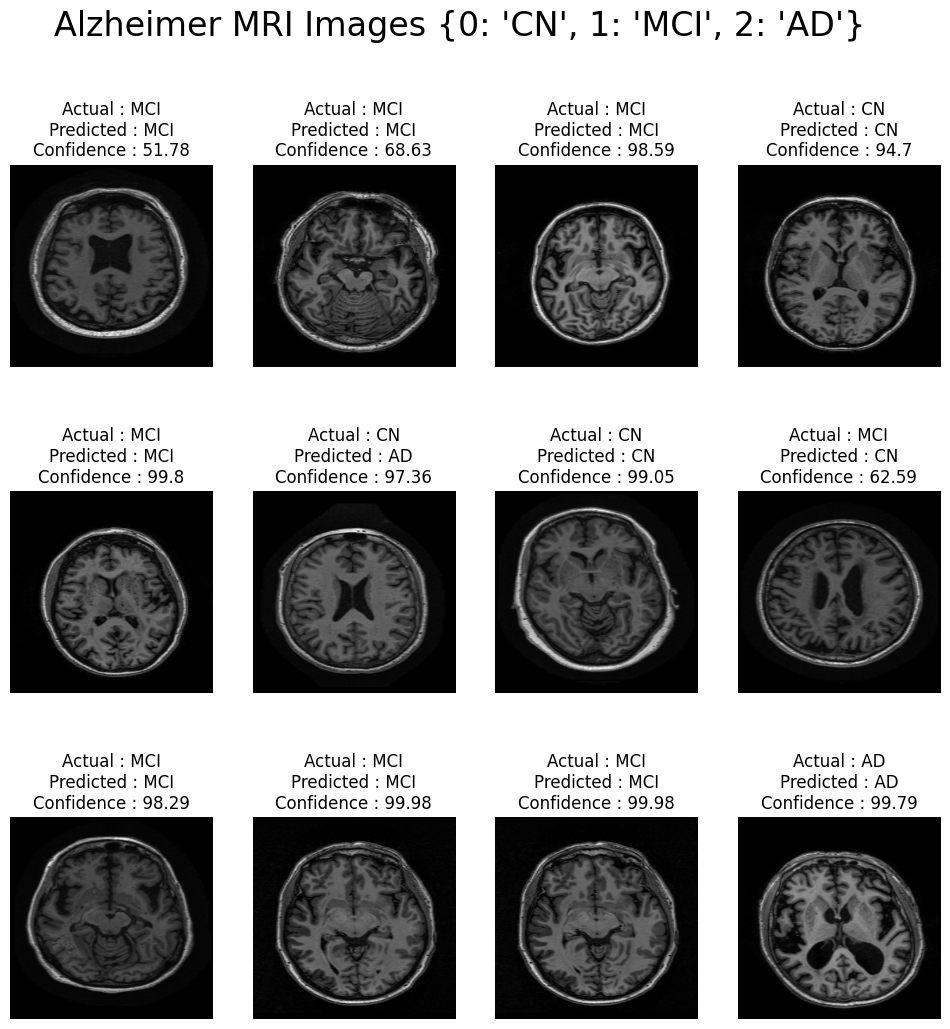

In [19]:
pred_plot(model1)

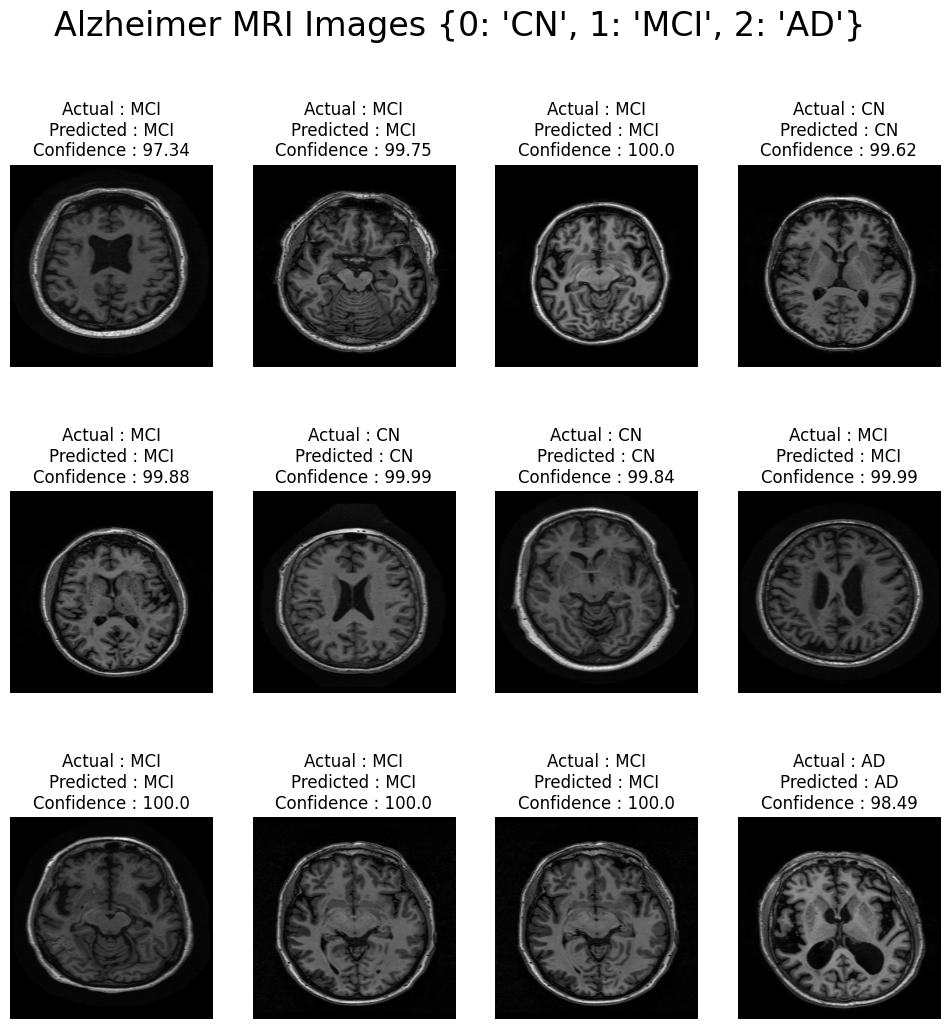

In [20]:
pred_plot(final_model)